In [1]:

# Dataclass Preparation
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import dlib
from imutils import face_utils
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import numpy as np
import os
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from glob import glob
# import segmentation_models_pytorch as smp
import torch.nn.functional as F
import cv2
import time 
import mediapipe
from torchvision import transforms
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import math
import albumentations as A
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision import models
import wandb
import sys
sys.path.append("../BaseModels")
from  unet_model import UNET
device = 'cuda' if torch.cuda.is_available() else 'cpu'




In [2]:
IMAGE_DIR = "/home/nipun/Documents/Uni_Malta/Datasets/CenterRegression/MixDataset/images"
trn_df = pd.read_csv("/home/nipun/Documents/Uni_Malta/Datasets/CenterRegression/MixDataset/trainAll.csv")
val_df = pd.read_csv("/home/nipun/Documents/Uni_Malta/Datasets/CenterRegression/MixDataset/valAll.csv")




In [3]:
def double_conv(input_channels,output_channels):
    return nn.Sequential(nn.Conv2d(input_channels,output_channels,kernel_size=3,stride=1,padding='same'),
                         nn.BatchNorm2d(output_channels),
                         nn.ReLU(),
                         nn.Conv2d(output_channels,output_channels,kernel_size=3,stride=1,padding='same'),
                         nn.BatchNorm2d(output_channels),
                         nn.ReLU())

In [4]:
class UNET(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        self.conv_1 = double_conv(3,64)
        self.mx_1 = nn.MaxPool2d(kernel_size=(2,2))
        
        
        self.conv_2 = double_conv(64,128)
        self.mx_2 = nn.MaxPool2d(kernel_size=(2,2))
        
        
        self.conv_3 = double_conv(128,256)
        self.mx_3 = nn.MaxPool2d(kernel_size=(2,2))
        
        
        
        self.conv_4 = double_conv(256,512)
        self.mx_4 = nn.MaxPool2d(kernel_size=(2,2))
        
        
        
        self.conv_5 = double_conv(512,1024)
        
        
        
        self.up_1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2)
        
        
        
        self.conv6 = double_conv(1024,512)
       
       
        self.up_2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        
        
        
        self.conv7 = double_conv(512,256)
        
        
        self.up_3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        
        
        self.conv8 = double_conv(256,128)
        

        self.up_4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        
        self.conv9 = double_conv(128,64)
        
        self.out_conv = nn.Conv2d(64,self.num_classes,kernel_size=1)
        
    def forward(self,x):

        
        x1 = self.conv_1(x)  # 1, 64, 64,64
        
        x1_max = self.mx_1(x1)
        
        
        
        x2 = self.conv_2(x1_max)  # 1, 128, 32, 32
        x2_max = self.mx_2(x2)
        
        x3 = self.conv_3(x2_max)  # 1, 256, 16,16
        x3_max = self.mx_3(x3)
        
        
        x4 = self.conv_4(x3_max) # 1, 512, 8, 8
        x4_max = self.mx_4(x4)
        
        
        
        # Bridge
        
        x5 = self.conv_5(x4_max)  # 1, 1024, 4, 4
       
        
        
        x6 = self.up_1(x5) # [1, 512, 8, 8]
      
        
        
        decoder_1 = torch.concat([x6,x4],dim=1) # 1, 1024, 8, 8]
        
        
        decoder_1 = self.conv6(decoder_1)  # [1, 512, 8, 8]
        
        
        
        
        d_2 = self.up_2(decoder_1)
        
        decoder_2 = torch.concat([d_2,x3],dim=1) # [1, 512, 16, 16]
        
        decoder_2 = self.conv7(decoder_2) # [1, 256, 16, 16]
        
       
        d_3 = self.up_3(decoder_2)
        
        decoder_3 = torch.concat([d_3,x2],dim=1)
        
        decoder_3 = self.conv8(decoder_3) # [1, 128, 32, 32]
        
        
        d_4 = self.up_4(decoder_3)
        decoder_4 = torch.concat([d_4,x1],dim=1)
        
        decoder_4 = self.conv9(decoder_4) # 1, 64, 64, 64
        
        output = self.out_conv(decoder_4)
        return output

In [5]:
def mean_squared_error(y_true,y_pred):
    """ Return MSE for the Batch"""
    return torch.sum(torch.square(y_pred-y_true),axis=-1).mean()

In [6]:


class CenterDataset(torch.utils.data.Dataset):
    def __init__(self,df,image_dir=IMAGE_DIR,RESIZE_AMT=256):
        
        self.RESIZE_AMT = RESIZE_AMT
        self.image_dir = image_dir
        self.df = df
        self.image_ids = df.Image_Name.unique()
        self.transforms = transforms
        
    # apply gaussian kernel to image
    def _gaussian(self, xL, yL, sigma, H, W):

        channel = [math.exp(-((c - xL) ** 2 + (r - yL) ** 2) / (2 * sigma ** 2)) for r in range(H) for c in range(W)]
        channel = np.array(channel, dtype=np.float32)
        channel = np.reshape(channel, newshape=(H, W))

        return channel
    
    
    
    
    # convert original image to heatmap
    def _convertToHM(self, img, keypoints, sigma=10):

        H = img.shape[0] 
        W =  img.shape[1]
        nKeypoints = len(keypoints)
        
        

        img_hm = np.zeros(shape=(H, W, nKeypoints // 2), dtype=np.float32)

        for i in range(0, nKeypoints // 2):
            x = keypoints[i * 2]
            y = keypoints[1 + 2 * i]

            channel_hm = self._gaussian(x, y, sigma, H, W)

            img_hm[:, :, i] = channel_hm
        

        return img_hm
    def __getitem__(self,ix):
        
        img_id = self.image_ids[ix]
        img_path = os.path.join(self.image_dir,img_id)
        
        img = cv2.imread(img_path)[:,:,::-1]
        
        
        img = cv2.resize(img,(self.RESIZE_AMT,self.RESIZE_AMT))
        
        img = img/255.0
        
        
        
        data = self.df[self.df["Image_Name"]==img_id]
        
        
        x1 = data["X1"].values[0] * self.RESIZE_AMT
        y1 = data["Y1"].values[0] * self.RESIZE_AMT
        
        
        # heatmap = torch.tensor(self._convertToHM(img,[x1,y1]),dtype=torch.float32).permute(2,0,1).view(1*self.RESIZE_AMT*self.RESIZE_AMT)
        
        
        heatmap = torch.tensor(self._convertToHM(img,[x1,y1]),dtype=torch.float32).permute(2,0,1)
        
        image = torch.tensor(img,dtype=torch.float32).permute(2,0,1)
        
        
        return image,heatmap,[x1,y1]
        
    def collate_fn(self,batch):
        return tuple(zip(*batch))
    
    def __len__(self):
        return len(self.image_ids)

In [7]:
train_ds = CenterDataset(trn_df)
test_ds = CenterDataset(val_df)

In [8]:
img,hm,_ = train_ds[5]

In [9]:
# heatmap2argmax(hm)

In [10]:
def heatmap2argmax(heatmap, scale=False):
    N, C, H, W = heatmap.shape
    index = heatmap.view(N,C,1,-1).argmax(dim=-1)
    pts = torch.cat([index%W, index//W], dim=2)
    
    if scale:
        scale = torch.Tensor([W,H], device=heatmap.device)
        pts = _scale(pts, scale)
    
    return pts


def _scale(p, s): return 2 * (p / s) - 1

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


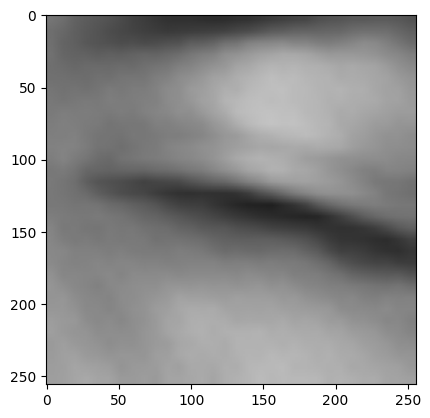

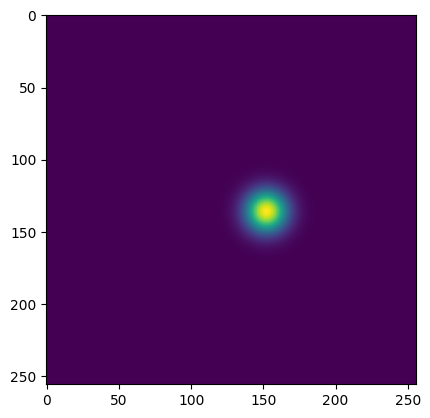

In [11]:
print(img.shape)
print(hm.shape)

plt.imshow(img.permute(1,2,0))
plt.show()
plt.imshow(hm.permute(1,2,0))

In [12]:
def generate_gaussian(t, x, y, sigma=10):
    """
    Generates a 2D Gaussian point at location x,y in tensor t.

    x should be in range (-1, 1) to match the output of fastai's PointScaler.

    sigma is the standard deviation of the generated 2D Gaussian.
    """
    h,w = t.shape

    # Heatmap pixel per output pixel
    mu_x = int(0.5 * (x + 1.) * w)
    mu_y = int(0.5 * (y + 1.) * h)

    tmp_size = sigma * 3

    # Top-left
    x1,y1 = int(mu_x - tmp_size), int(mu_y - tmp_size)

    # Bottom right
    x2, y2 = int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)
    if x1 >= w or y1 >= h or x2 < 0 or y2 < 0:
        return t

    size = 2 * tmp_size + 1
    tx = np.arange(0, size, 1, np.float32)
    ty = tx[:, np.newaxis]
    x0 = y0 = size // 2

    # The gaussian is not normalized, we want the center value to equal 1
    g = _gaussians[sigma] if sigma in _gaussians \
                else tensor(np.exp(- ((tx - x0) ** 2 + (ty - y0) ** 2) / (2 * sigma ** 2)))
    _gaussians[sigma] = g

    # Determine the bounds of the source gaussian
    g_x_min, g_x_max = max(0, -x1), min(x2, w) - x1
    g_y_min, g_y_max = max(0, -y1), min(y2, h) - y1

    # Image range
    img_x_min, img_x_max = max(0, x1), min(x2, w)
    img_y_min, img_y_max = max(0, y1), min(y2, h)

    t[img_y_min:img_y_max, img_x_min:img_x_max] = \
      g[g_y_min:g_y_max, g_x_min:g_x_max]

    return t

In [13]:
BACTH_SIZE = 1

In [14]:
trainLoader = DataLoader(train_ds, batch_size=BACTH_SIZE,
	shuffle=True, num_workers=os.cpu_count(), pin_memory=True,drop_last=True)
testLoader = DataLoader(test_ds, batch_size=BACTH_SIZE,
	num_workers=os.cpu_count(), pin_memory=True,drop_last=True)



In [15]:
x,y,z = next(iter(trainLoader))

In [18]:
model(x.to('cuda'))

tensor([[[[ 1.2893,  1.5197,  1.7037,  ...,  1.6448,  0.3327,  0.3438],
          [ 1.0674,  1.7266,  1.4146,  ...,  1.3216, -0.9037, -1.0433],
          [ 2.8433,  2.1897,  2.4110,  ...,  1.7747,  0.0745,  0.0047],
          ...,
          [ 2.3130,  3.5479,  1.5773,  ...,  0.8629,  1.8632,  0.6694],
          [ 4.3177,  3.3494,  2.9328,  ...,  3.5455,  1.1581, -0.4087],
          [ 2.3388,  0.3535,  0.9960,  ...,  0.1425,  1.0894,  0.2672]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)

In [19]:
heatmap2argmax(y)

/tmp/ipykernel_20182/1495853360.py:4: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  pts = torch.cat([index%W, index//W], dim=2)


tensor([[[171, 136]]])

In [ ]:
print(x.shape)

print(y.shape)

In [ ]:
y_true = [[2,2],
          [3,3]]

y_pred = [[4,4],
          [6,6]]

In [ ]:
x1 = torch.tensor(y_true)

x2 = torch.tensor(y_pred)

In [ ]:
# torch.sum(torch.square(y_pred-y_true),axis=-1).mean()

torch.square(x2-x1)

In [ ]:

torch.sum(torch.square(x2-x1),axis=-1)

In [ ]:
sigmoid = nn.Sigmoid()

In [ ]:
import torch
from torch import nn


# torch.log  and math.log is e based
class AdaptiveWingLoss(nn.Module):
    def __init__(self, omega=14, theta=0.5, epsilon=1, alpha=2.1):
        super(AdaptiveWingLoss, self).__init__()
        self.omega = omega
        self.theta = theta
        self.epsilon = epsilon
        self.alpha = alpha

    def forward(self, pred, target):
        '''
        :param pred: BxNxHxH
        :param target: BxNxHxH
        :return:
        '''

        y = target
        y_hat = pred
        delta_y = (y - y_hat).abs()
        delta_y1 = delta_y[delta_y < self.theta]
        delta_y2 = delta_y[delta_y >= self.theta]
        y1 = y[delta_y < self.theta]
        y2 = y[delta_y >= self.theta]
        loss1 = self.omega * torch.log(1 + torch.pow(delta_y1 / self.omega, self.alpha - y1))
        A = self.omega * (1 / (1 + torch.pow(self.theta / self.epsilon, self.alpha - y2))) * (self.alpha - y2) * (
            torch.pow(self.theta / self.epsilon, self.alpha - y2 - 1)) * (1 / self.epsilon)
        C = self.theta * A - self.omega * torch.log(1 + torch.pow(self.theta / self.epsilon, self.alpha - y2))
        loss2 = A * delta_y2 - C
        return (loss1.sum() + loss2.sum()) / (len(loss1) + len(loss2))

In [ ]:
criterion = AdaptiveWingLoss()

In [17]:

model = UNET(1).cuda()
pred = model(x.cuda())


# pred_sig = sigmoid(pred)

# pred.shape

In [ ]:
pred_1 = pred_sig[2].squeeze(0).detach().cpu().numpy()

print(pred_1.shape)

plt.imshow(pred_1)
plt.show()

In [ ]:
criterion(pred[0],y[0].cuda())

In [ ]:
criterion(pred[1],y[1].cuda())

In [ ]:
criterion(pred[2],y[2].cuda())

In [ ]:
criterion(pred[3],y[3].cuda())

In [ ]:
criterion(pred,y.cuda())

In [ ]:
def main(model,trainLoader,testLoader,optimizer,loss_fn,scheduler,epochs=100,):
    
        for epoch in range(epochs):
            train_epoch_loss = trainStep(model,trainLoader,optimizer,loss_fn)
            val_epoch_loss=valStep(model,testLoader,loss_fn)
            
            scheduler.step(val_epoch_loss)
            
            
            # print(f"Epoch {epoch+1}| Train AdaptiveWing Loss--> {train_epoch_loss}")
            # print(f"Epoch {epoch+1}| VAL Adaptive Loss--> {val_epoch_loss}")
    
            

In [ ]:
def trainStep(model,trainLoader,optimizer,loss_fn):
    
    model.train()
    
    epoch_loss = 0
    
    total_step = 0
    
    for _,(x,y) in enumerate(trainLoader):
        
        x = x.to(device)
        y = y.to(device)
        
        
        optimizer.zero_grad()
        
        y_pred = model(x)
        
        
        loss = loss_fn(y_pred,y)
        # loss = mean_squared_error(y,y_pred)
        
        # print(loss.item())
        loss.backward()
        optimizer.step()
        
        
        epoch_loss += loss.item()
        
        # total_step += 1
        
        
        
        total_step += x[0]
        
    return epoch_loss
    # print(epoch_loss/total_step)
    # return epoch_loss/total_step
        
        
        

In [ ]:
trainStep(model,testLoader,optimizer,criterion)

In [ ]:
def valStep(model,testLoader,loss_fn,visualize=True):
    model.eval()
    
    
    total_val_loss = 0
   
    
    total_step = 0
    
    for (x,y) in testLoader:
        
        x = x.to(device)
        y = y.to(device)
        
        with torch.no_grad():
            
            y_pred = model(x)
        
        #MSE
        # loss = mean_squared_error(y,y_pred).item()
        
        loss = loss_fn(y_pred,y)
        
        total_val_loss += loss.item()
        
        
        
        
        total_step += x.shape[0]
  
    fig,axes = plt.subplots(x.shape[0],3)
    axes[0][0].set_title("Image")  
    axes[0][1].set_title("GT HeatMap")
    axes[0][2].set_title("Pred HeatMap")
    for i in range(x.shape[0]):
        
        img = x[i].squeeze(0).permute(1,2,0).detach().cpu().numpy()
        gt = y[i].squeeze(0).detach().cpu().numpy()
        heatMap = y_pred[i].squeeze(0).detach().cpu().numpy()
        
        
        axes[i][0].imshow(img)
        axes[i][1].imshow(gt)
        axes[i][2].imshow(heatMap)
        
        
        axes[i][0].axis('off')
        axes[i][1].axis('off')
        axes[i][2].axis('off')
        
    plt.tight_layout()
    plt.show()
    plt.close("all")
    
    return total_val_loss
        

In [ ]:
valStep(model,testLoader,criterion)

In [ ]:
def maskToKeypoints(mask):
    
    
    
    kp = np.unravel_index(np.argmax(mask, axis=None), dims=(64,64))
    return kp[1], kp[0]

def findCoordinates(mask):

    hm_sum = np.sum(mask)

    index_map = [j for i in range(64) for j in range(64)]
    index_map = np.reshape(index_map, newshape=(64,64))

    x_score_map = mask * index_map / hm_sum
    y_score_map = mask * np.transpose(index_map) / hm_sum

    px = np.sum(np.sum(x_score_map, axis=None))
    py = np.sum(np.sum(y_score_map, axis=None))

    return px, py

def calcRMSError(kps_gt, kps_preds):

    N = kps_gt.shape[0] * (kps_gt.shape[-1] // 2)
    error = np.sqrt(np.sum((kps_gt-kps_preds)**2)/N)

    return error

In [ ]:
model = UNET(1).to(device)

lr = 0.001
criterion = AdaptiveWingLoss()

n_epoch = 100

parameters = filter(lambda p: p.requires_grad,model.parameters())

optimizer = torch.optim.Adam(parameters,lr=lr)



scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        lr,
        n_epoch,
        steps_per_epoch=len(train_ds)//BACTH_SIZE
    )

In [ ]:
main(model,trainLoader,testLoader,optimizer,loss_fn=criterion,scheduler=scheduler,epochs=n_epoch)



In [ ]:
x,y = next(iter(testLoader))

In [ ]:
pred_output = model(x.cuda())

In [ ]:
unflatten = nn.Unflatten(-1,(1,64,64))

In [ ]:
pred_output = unflatten(pred_output)




In [ ]:
idx = 3

In [ ]:
plt.imshow(pred_output[idx].permute(1,2,0).detach().cpu().numpy())

In [ ]:
y_true = unflatten(y)

plt.imshow(y_true[idx].permute(1,2,0).detach().cpu().numpy())

In [ ]:
x = torch.tensor([[1.,2.],
                  [3.,4.]])


y =  torch.tensor([[4.,5.],
                  [1.,2.]])

In [ ]:
def calcKeypoints(model, gen):
    kps_gt = []
    kps_preds = []
    
    image_array = []
    gt_mask_array =[]
    pred_mask_array =[]
    nbatches = len(gen)
    
    unflatter = nn.Unflatten(1,(64,64))
    
    model.eval()
    
    for (x,y) in gen:
        
        x = x.to(device)
        y= y.to(device)
        
        with torch.no_grad():
            y_pred = model(x)
            
        for i in range(x.shape[0]):
            
            
            imgs = x[i].detach().cpu().permute(1,2,0).numpy()
            
            mask_gt = y[i]
            
            mask_gt = unflatten(mask_gt).detach().cpu().permute(1,2,0).numpy()
            
           
            
            mask_pred = y_pred[i]
            
            mask_pred = unflatten(mask_pred).detach().cpu().permute(1,2,0).numpy()


            
            xgt, ygt = findCoordinates(mask_gt[:, :,0])
            
            xpred, ypred = findCoordinates(mask_pred[:, :,0])
            

            image_array.append(imgs)
            gt_mask_array.append(mask_gt)
            pred_mask_array.append(mask_pred)
                        
            kps_gt.append([xgt,ygt])
            kps_preds.append([xpred,ypred])
    
    
    return image_array, gt_mask_array, pred_mask_array,kps_gt,kps_preds

        

In [ ]:

# len(testLoader)

image_array, gt_mask_array, pred_mask_array,kps_gt,kps_preds = calcKeypoints(model, testLoader)


In [ ]:

len(kps_preds)

In [ ]:
def showMasks(imgs, gt_masks, pred_masks, gt_coord, pred_coord, nrows=8, ncols=4):

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 25))
    plt.figure(figsize=(8, 8))

    axs[0, 0].set_title("Original Image")
    axs[0, 1].set_title("GT Masks")
    axs[0, 2].set_title("Pred Masks")
    axs[0, 3].set_title("Pred & GT Coord")


    for i in range(len(imgs)):

        axs[i, 0].imshow(imgs[i])
        axs[i, 0].axis("off")

        axs[i, 1].imshow(gt_masks[i])
        axs[i, 1].axis("off")

        axs[i, 2].imshow(pred_masks[i])
        axs[i, 2].axis("off")

        axs[i, 3].imshow(imgs[i])
        axs[i, 3].scatter(x=int(pred_coord[i][0]), y=int(
            pred_coord[i][1]), color='blue')  # Prediction Blue
        axs[i, 3].scatter(x=int(gt_coord[i][0]), y=int(
            gt_coord[i][1]), color="red")  # Ground Truth Red
        axs[i, 3].axis("off")

    plt.show()
    plt.close()


In [ ]:
low_limit = 50
upper_limit = 58

In [ ]:
showMasks(image_array[low_limit:upper_limit], gt_mask_array[low_limit:upper_limit], pred_mask_array[low_limit:upper_limit],kps_gt[low_limit:upper_limit],kps_preds[low_limit:upper_limit])

In [ ]:
class WingLoss(nn.Module):
    def __init__(self, width=5, curvature=0.5):
        super(WingLoss, self).__init__()
        self.width = width
        self.curvature = curvature
        self.C = self.width - self.width * np.log(1 + self.width / self.curvature)

    def forward(self, prediction, target):
        diff = target - prediction
        
        diff_abs = diff.abs()
        
        loss = diff_abs.clone()
        

        idx_smaller = diff_abs < self.width
        idx_bigger = diff_abs >= self.width
        
        
        loss[idx_smaller] = self.width * torch.log(1 + diff_abs[idx_smaller] / self.curvature)
        loss[idx_bigger]  = loss[idx_bigger] - self.C
        
        
    
        return  loss
        
        
        
        

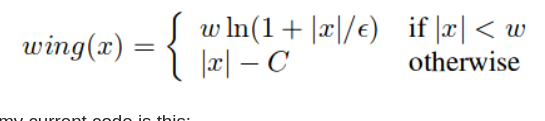

In [ ]:
x = torch.tensor([[1.,2.],
                  [3.,4.]])


y = torch.tensor([[4.,5.],
                  [6.,8.]])

In [ ]:
wingLoss = WingLoss()




In [ ]:
loss = wingLoss(y,x)

In [ ]:
# loss.sum(1).sum()

In [ ]:
z<5

In [ ]:
z>=5

#Adaptive Wing Loss analysis

In [ ]:
import torch
from torch.utils.data import  Dataset,DataLoader
from torchvision import transforms 
from scipy import interpolate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from scipy import  ndimage
from scipy.ndimage.morphology import  grey_dilation
import math
from PIL import  Image
import  warnings
warnings.filterwarnings("ignore")


class face300w(Dataset):
    
    def __init__(self,root):
        self.root = root
        entry_point = os.listdir(root)
        print(entry_point)
        self.ptsPath = list()
        self.imgPath = list()
        
        self.crop_pad = 30
        
        
        for i in entry_point:
            files = os.listdir(root+"/"+i)
            
            for f in files:
                
                if (f[-3:] == "png"):
                    self.imgPath.append(i+"/"+f)
                    
                elif (f[-3:] == "pts"):
                    self.ptsPath.append(i+"/"+f)
                else:
                    print("WrongFormat"
                          )
                    
        self.ptsPath.sort()
        self.imgPath.sort()
        self.frame = True
        self.resize = 256
        
        
        
    def __getitem__(self,idx):
        imgPath = self.root + "/" + self.imgPath[idx]
        ptsPath = self.root + "/" + self.ptsPath[idx]
        
        img = plt.imread(imgPath) #RGT
        # print(img.shape)
        # plt.imshow(img)
        # plt.show()
        
        
        if (len(img.shape)==2):
            
            # gray to RGB
            img = img.reshape(img.shape[0],img.shape[1],1)
            img = np.repeat(img,3,axis=2)
            
        w,h,c = img.shape
        
        with open(ptsPath) as ptsf:
            rows = [rows.strip() for rows in ptsf][3:-1]
            
            if len(rows)!= 68:
                print("points are not 68")
                return None
            
            toFloat = lambda lst: [float(i) for i in lst] 
            
            rows =[toFloat(pair.split(" ")) for pair in rows]
            
            rows = np.array(rows)
            
            
            minx,maxx = rows[:,0].min(),rows[:,0].max()
            miny,maxy = rows[:,1].min(),rows[:,1].max()
            
            face_h = maxx-minx
            
            # plt.imsho
            
            if(self.frame):
                csh = img.shape #534 950
                print(csh)
                frame = np.zeros((max(csh[0],csh[1]),max(csh[0],csh[1]),3)) # 950 950
                
                
                frame_ctr = np.array([max(csh[0],csh[1])//2,max(csh[0],csh[1])//2]) # [475,475]
                
                
                frame[math.ceil(frame_ctr[0]-csh[0]/2.):math.ceil(frame_ctr[0]+csh[0]/2.),
                  math.ceil(frame_ctr[1]-csh[1]/2.):math.ceil(frame_ctr[1]+csh[1]/2.),:] = img
                
                if(csh[1] != frame.shape[1]):
              
                    rows[:,0] += (frame.shape[0]-csh[1])/2.
                else:
                    #새로패딩
                    rows[:,1] += (frame.shape[0]-csh[0])/2.


                if(self.resize != None):
                    rows /= frame.shape[0]
                    frame = cv2.resize(frame, dsize=(self.resize, self.resize), interpolation=cv2.INTER_LINEAR)
                    rows *= float(self.resize)
                    
                    
                hmap = np.zeros((68+1,64,64),dtype=np.float32)
                
                M = np.zeros((68+1,64,64),dtype=np.float32)
                
                
                for ind,xy in enumerate(rows):
                    hmap[ind] = draw_umich_gaussian(hmap[ind], xy/256.*64, 7)
                    
                hmap[-1] = draw_boundary(hmap[-1],np.clip((rows/256.*64).astype(np.int),0,63))

                for i in range(len(M)):
                    
                    M[i] = grey_dilation(hmap[i], size=(3,3))
                M = np.where(M>=0.5, 1, 0)

                return frame, hmap , M, rows
    

In [ ]:
math.ceil(475 +950/2)

In [ ]:
dataset_dir = "/home/nipun/Downloads/300w/"


dataset = face300w(dataset_dir)

img,hmap,M,pts = dataset[45]



In [ ]:
# img.shape # (256, 256, 3)
plt.imshow(hmap[68]) # (69,69)
# hmap[9].shape

In [ ]:
def gaussian2D(shape, sigma=1):
    
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def draw_umich_gaussian(heatmap, center, radius, k=1):
    
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0:  # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap

In [ ]:
plt.subplot(3,1,1)
plt.imshow(img)
plt.imshow(cv2.resize(hmap[-1], dsize=(256, 256), interpolation=cv2.INTER_AREA),alpha=0.3)
plt.subplot(3,1,2)
plt.imshow(np.max(hmap[:68], axis=0))
plt.subplot(3,1,3)
plt.imshow(np.max(M[:68], axis=0))

plt.show()

In [ ]:
def drawline(img,annots):
    shape = img.shape
    points_cnt = annots.shape[0]
    heatmap = np.zeros((shape[0],shape[1]))
    
    heatmap[[list(annots[:,1]),list(annots[:,0])]] = 1
    """
    for p in range(points_cnt-1):
        heatmap = cv2.line(heatmap,tuple(annots[p,:]),tuple(annots[p+1,:]),(255,255,255),thickness=5)

    heatmap = heatmap.astype(np.float32)
    annots = annots.astype(np.int)
    heatmap = cv2.polylines(heatmap, [annots], False, (255,255,255), thickness=3, lineType=cv2.LINE_AA)
    """

    annots = annots.astype(np.float64)
    x,y = annots[:,0],annots[:,1]
    l=len(x)
    t=np.linspace(0,1,l-2,endpoint=True)
    t=np.append([0,0,0],t)
    t=np.append(t,[1,1,1])
    tck=[t,[x,y],3]
    u3=np.linspace(0,1,(max(l*2,500)),endpoint=True)
    out = interpolate.splev(u3,tck)
    heatmap[[list(out[1].astype(np.int)),list(out[0].astype(np.int))]] = 1

    return heatmap

In [ ]:
def draw_boundary(img,annot):
    heatmap = np.zeros((64,64))

    heatmap += drawline(img,annot[0:17,:])
    heatmap += drawline(img,annot[17:22,:])
    heatmap += drawline(img,annot[22:27,:])
    heatmap += drawline(img,annot[36:40,:])
    heatmap += drawline(img, np.array([annot[i] for i in [36, 41, 40, 39]]))
    heatmap += drawline(img,annot[42:46,:])
    heatmap += drawline(img, np.array([annot[i] for i in [42, 47, 46, 45]]))
    heatmap += drawline(img,annot[27:31,:])
    heatmap += drawline(img,annot[31:36,:])
    heatmap += drawline(img,annot[48:55,:])
    heatmap += drawline(img, np.array([annot[i] for i in [60, 61, 62, 63, 64]]))
    heatmap += drawline(img, np.array([annot[i] for i in [48, 59, 58, 57, 56, 55, 54]]))
    heatmap += drawline(img, np.array([annot[i] for i in [60, 67, 66, 65, 64]]))
    heatmap = np.clip(heatmap,0,1).astype(np.uint8)*255

    heatmap = 255-heatmap
    dist_transform = cv2.distanceTransform(heatmap, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
    dist_transform = dist_transform.astype(np.float64)
    sigma = 1
    gt = np.where(dist_transform < 3*sigma, np.exp(-(dist_transform*dist_transform)/(2*sigma*sigma)), 0 )

    return gt

In [ ]:
x = [[1,2,3],
     [4,5,6]]



row = len(x) 2 3 --> 3 2
column = len(x[0])


In [ ]:
zeros_array = [ [0] * row for _ in range(column)]



In [ ]:

column = 0
for row_idx,row in enumerate(x):
    
  

    while column<=2:
        print(column)
        
        zeros_array[column ][row_idx] = row[column]
        column +=1
    column = 0
    

In [ ]:
zeros_array

In [ ]:
import torch
import torch.nn as nn

In [ ]:
conv2d = nn.Conv2d(3,6,kernel_size=3,padding=1
                   )

In [ ]:
conv2d

In [ ]:
import tensorflow as tf

In [ ]:
x_range = tf.expand_dims(tf.range([6]),0) # 1,6

In [ ]:
xx_range = tf.tile(x_range,[2,1])

In [ ]:
xx_range

In [ ]:
x= tf.random.uniform(shape=[2,28,1])

In [ ]:
y = tf.random.uniform(shape=[2,1,30])

In [ ]:
out = tf.matmul(x,y)

In [ ]:
out.shape

In [ ]:
5!


5--> 5*4*3*2*1

In [ ]:
def factorial(n):
    
    if n==1:
        return 1
    return n *factorial(n-1)

In [ ]:
class Node:
    def __init__(self,val):
        self.val = val
        self.next = None

In [ ]:
l1 = LinkedList()

In [ ]:
l1.insert(1)

In [ ]:
l1.insert(2)

In [ ]:
l1.insert(3)

In [ ]:
l1.addBegining(5)

In [ ]:
l1.addMiddle(1,6)

In [ ]:
l1.print()

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import dlib
from imutils import face_utils
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import numpy as np
import os
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from glob import glob
import segmentation_models_pytorch as smp
import torch.nn.functional as F
import cv2
import time 
import mediapipe
from torchvision import transforms
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import math
import albumentations as A
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision import models
import wandb
import sys
sys.path.append("../BaseModels")
from  unet_model import UNET
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = "cpu"

RESIZE_AMT = 64

In [ ]:
import torch
import torch.nn as nn

# '''
#      Instantiate the object like:
#           criterion = AdaptiveWingLoss(whetherWeighted=True)
#      #param whetherWeighted: whether use weighted loss map
#      #param dilaStru: size of dilation structure
# '''
class AdaptiveWingLoss(nn.Module):
  def __init__(self, alpha=2.1, omega=14.0, theta=0.5, epsilon=1.0,\
               whetherWeighted=False, dilaStru=3, w=10, device=device):
    super(AdaptiveWingLoss, self).__init__()
    self.device = device
    self.alpha = torch.Tensor([alpha]).to(device)
    self.omega = torch.Tensor([omega]).to(device)
    self.theta = torch.Tensor([theta]).to(device)
    self.epsilon = torch.Tensor([epsilon]).to(device)
    self.dilationStru = dilaStru
    self.w = torch.Tensor([w]).to(device)
    self.tmp = torch.Tensor([self.theta / self.epsilon]).to(device)
    self.wetherWeighted = whetherWeighted

# '''
#    #param predictions: predicted heat map with dimension of batchSize * landmarkNum * heatMapSize * heatMapSize  
#    #param targets: ground truth heat map with dimension of batchSize * landmarkNum * heatMapSize * heatMapSize  
# '''
  def forward(self, predictions, targets):
    
    
    deltaY = predictions - targets
    deltaY = torch.abs(deltaY)
    alphaMinusY = self.alpha - targets
    
    
    a = self.omega / self.epsilon * alphaMinusY / (1 + self.tmp.pow(alphaMinusY))\
        * self.tmp.pow(alphaMinusY - 1)
    c = self.theta * a - self.omega * torch.log(1 + self.tmp.pow(alphaMinusY))

    l = torch.where(deltaY < self.theta,
                    self.omega * torch.log(1 + (deltaY / self.epsilon).pow(alphaMinusY)),
                    a * deltaY - c)
    if self.wetherWeighted:
      weightMap = self.grayDilation(targets, self.dilationStru)
      weightMap = torch.where(weightMap >= 0.2, torch.Tensor([1]).to(self.device),\
                              torch.Tensor([0]).to(self.device))
      l = l * (self.w * weightMap + 1)

    l = torch.mean(l)

    return l
    
  def grayDilation(self, heatmapGt, structureSize):
    batchSize, landmarkNum, heatmapSize, _ = heatmapGt.shape
    weightMap = heatmapGt.clone()
    step = structureSize // 2
    for i in range(1, heatmapSize-1, 1):
      for j in range(1, heatmapSize-1, 1):
        weightMap[:, :, i, j] = torch.max(heatmapGt[:, :, i - step: i + step + 1,\
                                j - step: j + step + 1].contiguous().view(batchSize,\
                                landmarkNum, structureSize * structureSize), dim=2)[0]

    return weightMap

In [ ]:

IMAGE_DIR = "/home/nipun/Documents/Uni_Malta/Datasets/CenterRegression/MixDataset/images"
trn_df = pd.read_csv("/home/nipun/Documents/Uni_Malta/Datasets/CenterRegression/MixDataset/trainAll.csv")
val_df = pd.read_csv("/home/nipun/Documents/Uni_Malta/Datasets/CenterRegression/MixDataset/valAll.csv")



In [ ]:
class CenterDataset(torch.utils.data.Dataset):
    def __init__(self,df,image_dir=IMAGE_DIR,RESIZE_AMT=RESIZE_AMT):
        
        self.RESIZE_AMT = RESIZE_AMT
        self.image_dir = image_dir
        self.df = df
        self.image_ids = df.Image_Name.unique()
        self.transforms = transforms
        
    # apply gaussian kernel to image
    def _gaussian(self, xL, yL, sigma, H, W):

        channel = [math.exp(-((c - xL) ** 2 + (r - yL) ** 2) / (2 * sigma ** 2)) for r in range(H) for c in range(W)]
        channel = np.array(channel, dtype=np.float32)
        channel = np.reshape(channel, newshape=(H, W))

        return channel
    
    
    
    
    # convert original image to heatmap
    def _convertToHM(self, img, keypoints, sigma=2):

        H = img.shape[0] 
        W =  img.shape[1]
        nKeypoints = len(keypoints)

        img_hm = np.zeros(shape=(H, W, nKeypoints // 2), dtype=np.float32)

        for i in range(0, nKeypoints // 2):
            x = keypoints[i * 2]
            y = keypoints[1 + 2 * i]

            channel_hm = self._gaussian(x, y, sigma, H, W)

            img_hm[:, :, i] = channel_hm
            
        return img_hm
    def __getitem__(self,ix):
        
        img_id = self.image_ids[ix]
        img_path = os.path.join(self.image_dir,img_id)
        
        img = cv2.imread(img_path)[:,:,::-1]
        
        
        img = cv2.resize(img,(self.RESIZE_AMT,self.RESIZE_AMT))
        
        img = img/255.0
        
        
        
        data = self.df[self.df["Image_Name"]==img_id]
        
        
        x1 = data["X1"].values[0] * self.RESIZE_AMT
        y1 = data["Y1"].values[0] * self.RESIZE_AMT
        
        
        heatmap = torch.tensor(self._convertToHM(img,[x1,y1]),dtype=torch.float32).permute(2,0,1)#.view(1*self.RESIZE_AMT*self.RESIZE_AMT)
        
        image = torch.tensor(img,dtype=torch.float32).permute(2,0,1)
        
        
        return image,heatmap
        
    def collate_fn(self,batch):
        return tuple(zip(*batch))
    
    def __len__(self):
        return len(self.image_ids) 

In [ ]:
BACTH_SIZE = 512
train_ds = CenterDataset(trn_df)
test_ds = CenterDataset(val_df)

trainLoader = DataLoader(train_ds, batch_size=BACTH_SIZE,
	shuffle=True, num_workers=os.cpu_count(), pin_memory=True,drop_last=True)
testLoader = DataLoader(test_ds, batch_size=BACTH_SIZE,
	num_workers=os.cpu_count(), pin_memory=True,drop_last=True)

In [ ]:
x,y = next(iter(trainLoader))

In [ ]:
# heatmap = y[0].permute(1,2,0).detach().cpu().numpy()




In [ ]:
batchSize, landmarkNum, heatmapSize, _ = y.shape

weightMap = y.clone()
structureSize=3
step = structureSize // 2
for i in range(1, heatmapSize-1, 1):
  for j in range(1, heatmapSize-1, 1):
    weightMap[:, :, i, j] = torch.max(y[:, :, i - step: i + step + 1,\
                            j - step: j + step + 1].contiguous().view(batchSize,\
                            landmarkNum, structureSize * structureSize), dim=2)[0]

In [ ]:

dilated_mask = weightMap[1].permute(1,2,0).detach().cpu().numpy()


plt.imshow(dilated_mask)

In [ ]:

def double_conv(input_channels,output_channels):
    return nn.Sequential(nn.Conv2d(input_channels,output_channels,kernel_size=3,stride=1,padding='same'),
                         nn.BatchNorm2d(output_channels),
                         nn.ReLU(),
                         nn.Conv2d(output_channels,output_channels,kernel_size=3,stride=1,padding='same'),
                         nn.BatchNorm2d(output_channels),
                         nn.ReLU())
    
    
class UNET(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        self.conv_1 = double_conv(3,64)
        self.mx_1 = nn.MaxPool2d(kernel_size=(2,2))
        
        
        self.conv_2 = double_conv(64,128)
        self.mx_2 = nn.MaxPool2d(kernel_size=(2,2))
        
        
        self.conv_3 = double_conv(128,256)
        self.mx_3 = nn.MaxPool2d(kernel_size=(2,2))
        
        
        
        self.conv_4 = double_conv(256,512)
        self.mx_4 = nn.MaxPool2d(kernel_size=(2,2))
        
        
        
        self.conv_5 = double_conv(512,1024)
        
        
        
        self.up_1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2)
        
        
        
        self.conv6 = double_conv(1024,512)
       
       
        self.up_2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        
        
        
        self.conv7 = double_conv(512,256)
        
        
        self.up_3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        
        
        self.conv8 = double_conv(256,128)
        

        self.up_4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        
        self.conv9 = double_conv(128,64)
        
        self.out_conv = nn.Conv2d(64,self.num_classes,kernel_size=1)
        
    def forward(self,x):

        
        x1 = self.conv_1(x)  # 1, 64, 64,64
        
        x1_max = self.mx_1(x1)
        
        #################
        
        x2 = self.conv_2(x1_max)  # 1, 128, 32, 32
        x2_max = self.mx_2(x2)
        #################
        x3 = self.conv_3(x2_max)  # 1, 256, 16,16
        x3_max = self.mx_3(x3)
        ################
        
        x4 = self.conv_4(x3_max) # 1, 512, 8, 8
        x4_max = self.mx_4(x4)
        
        #################
        
        # Bridge
        
        x5 = self.conv_5(x4_max)  # 1, 1024, 4, 4
       
        ####################
        
        x6 = self.up_1(x5) # [1, 512, 8, 8]
      
        
        
        decoder_1 = torch.concat([x6,x4],dim=1) # 1, 1024, 8, 8
        
        
        decoder_1 = self.conv6(decoder_1)  # [1, 512, 8, 8]
        
        
        
        
        d_2 = self.up_2(decoder_1)
        
        decoder_2 = torch.concat([d_2,x3],dim=1) # [1, 512, 16, 16]
        
        decoder_2 = self.conv7(decoder_2) # [1, 256, 16, 16]
        
       
        d_3 = self.up_3(decoder_2)
        
        decoder_3 = torch.concat([d_3,x2],dim=1)
        
        decoder_3 = self.conv8(decoder_3) # [1, 128, 32, 32]
        
        
        d_4 = self.up_4(decoder_3)
        decoder_4 = torch.concat([d_4,x1],dim=1)
        
        decoder_4 = self.conv9(decoder_4) # 1, 64, 64, 64
        
        output = self.out_conv(decoder_4)
        
        return output

In [ ]:
unet= UNET(num_classes=1)

In [ ]:
pred = unet(x)

pred.shape

In [ ]:
# pred.device

# y.device

In [ ]:
criterion = AdaptiveWingLoss(whetherWeighted=True)


In [ ]:
criterion(x,y)

In [ ]:
# 1.4971
# 1.1691

In [ ]:
def trainStep(model,trainLoader,optimizer,loss_fn):
    
    model.train()
    
    epoch_loss = 0
    
    total_step = 0
    
    for _,(x,y) in enumerate(trainLoader):
        
        x = x.to(device)
        y = y.to(device)
        
        
        optimizer.zero_grad()
        
        y_pred = model(x)
        
        loss = loss_fn(y_pred,y)
        
        
        loss.backward()
        optimizer.step()
        
        
        epoch_loss += loss.item()
        
        total_step += 1
        
    return epoch_loss/len(trainLoader)

In [ ]:
def valStep(model,testLoader,loss_fn):
    model.eval()
    
    
    total_val_mse_loss = 0
    total_val_jaccard_index = 0
    
    total_step = 0
    
    for (x,y) in testLoader:
        
        x = x.to(device)
        y = y.to(device)
        
        with torch.no_grad():
            
            y_pred = model(x)
        
    
        loss = loss_fn(y_pred,y).item()
        
        total_val_mse_loss += loss
        
       
        
    return total_val_mse_loss/len(testLoader)

In [ ]:
def main(model,trainLoader,testLoader,optimizer,loss_fn,epochs=100):
    
    
    val_loss = 0
    
    for epoch in range(epochs):
        
        
        
        
        trainLoss=trainStep(model,trainLoader,optimizer,loss_fn)
        valLoss=valStep(model,testLoader,loss_fn)
        
        
        if epoch==0:
            val_loss = valLoss
            
        elif val_loss<valLoss  and abs(val_loss-valLoss) > 0.2:
            
            model_name = f"hm_model_{str(val_loss)}.pth"
            torch.save(model, model_name)

            
        
        
        
        
        print(f"Epoch {epoch+1}| Train MSE Loss--> {train_epoch_mse_loss}")
        print(f"Epoch {epoch+1}| VAL MSE Loss--> {val_mse}")
        print(f"Epoch {epoch+1}| VAL Jaccard Loss--> {val_jaccard}\n")

In [ ]:
model = UNET(num_classes=1)
parameters = filter(lambda p: p.requires_grad,model.parameters())

optimizer = torch.optim.Adam(parameters,lr=0.006)

main(model,trainLoader,testLoader,optimizer,criterion,epochs=100)

In [ ]:
import torch
import torch.nn as nn

class AddCoords(nn.Module):

    def __init__(self, with_r=False, with_boundary=False):
        super().__init__()
        self.with_r = with_r
        self.with_boundary = with_boundary

    def forward(self, input_tensor, boundary_map):
        """
        Args:
            input_tensor: shape(batch, channel, x_dim, y_dim)
        """
        batch_size, _, x_dim, y_dim = input_tensor.size()

        xx_channel = torch.arange(x_dim).repeat(1, y_dim, 1)
        yy_channel = torch.arange(y_dim).repeat(1, x_dim, 1).transpose(1, 2)

        xx_channel = xx_channel.float() / (x_dim - 1)
        yy_channel = yy_channel.float() / (y_dim - 1)

        xx_channel = xx_channel * 2 - 1
        yy_channel = yy_channel * 2 - 1

        xx_channel = xx_channel.repeat(batch_size, 1, 1, 1).transpose(2, 3).cuda()
        yy_channel = yy_channel.repeat(batch_size, 1, 1, 1).transpose(2, 3).cuda()

        ret = torch.cat([
            input_tensor,
            xx_channel.type_as(input_tensor),
            yy_channel.type_as(input_tensor)], dim=1)

        if self.with_r:
            rr = torch.sqrt(torch.pow(xx_channel.type_as(input_tensor) - 0.5, 2) + torch.pow(yy_channel.type_as(input_tensor) - 0.5, 2))
            ret = torch.cat([ret, rr], dim=1)

        if self.with_boundary and (boundary_map is not None):
            # B, 64(H), 64(W)
            boundary_map = boundary_map.view(boundary_map.shape[0],1,boundary_map.shape[1],boundary_map.shape[2])
            boundary_channel = torch.clamp(boundary_map,0.0, 1.0)
            zero_tensor = torch.zeros_like(xx_channel)
            xx_boundary_channel = torch.where(boundary_channel>0.05, xx_channel, zero_tensor)
            yy_boundary_channel = torch.where(boundary_channel>0.05, yy_channel, zero_tensor)

            ret = torch.cat([ret, xx_boundary_channel, yy_boundary_channel], dim=1)

        return ret


class CoordConv(nn.Module):

    def __init__(self, in_channels, out_channels, with_r=True, with_boundary=False,**kwargs):
        super().__init__()
        self.addcoords = AddCoords(with_r=with_r,with_boundary=with_boundary)
        in_size = in_channels+2
        if with_r:
            in_size += 1
        if with_boundary:
            in_size += 2
        self.conv = nn.Conv2d(in_size, out_channels, **kwargs)

    def forward(self, x, boundary_map=None):
        ret = self.addcoords(x, boundary_map)
        ret = self.conv(ret)
        return ret




In [ ]:
 x = torch.randn(1,3,633,357)
coordconv1 = CoordConv(3,64,kernel_size=3,padding=1)
out = coordconv1(x)
print(out.shape)

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo


__all__ = ['MobileNetV2', 'mobilenetv2']


DEBUG=False

class Block(nn.Module):
    """ 
    Bottleneck Residual Block
    
    """
    def __init__(self, in_channels, out_channels, expansion=1, stride=1):
        super(Block, self).__init__()
        if expansion == 1:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, in_channels, 3, stride, 1, groups=in_channels, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU6(inplace=True),
                nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        else:
            channels = expansion * in_channels
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, channels, 1, 1, 0, bias=False),
                nn.BatchNorm2d(channels),
                nn.ReLU6(inplace=True),
                nn.Conv2d(channels, channels, 3, stride, 1, groups=channels, bias=False),
                nn.BatchNorm2d(channels),
                nn.ReLU6(inplace=True),
                nn.Conv2d(channels, out_channels, 1, 1, 0, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        self.residual = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        out = self.conv(x)
        if self.residual:
            out = out + x
        return out


class MobileNetV2(nn.Module):
    def __init__(self, config):
        super(MobileNetV2, self).__init__()
        in_channels = config[0][1]
        features = [nn.Sequential(
            nn.Conv2d(3, in_channels, 3, 2, 1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU6(inplace=True)
        )]
        for expansion, out_channels, blocks, stride in config[1:]:
            for i in range(blocks):
                features.append(Block(in_channels, out_channels, expansion, stride if i == 0 else 1))
                in_channels = out_channels
        self.features = nn.Sequential(*features)

    def forward(self, x):
        c2 = self.features[:4](x)
        c3 = self.features[4:7](c2)
        c4 = self.features[7:14](c3)
        kwargs = {'size': c2.shape[-2:],'mode': 'bilinear','align_corners': False}
        features =  torch.cat([F.interpolate(xx,**kwargs) for xx in [c2,c3,c4]], 1)

        if DEBUG:
            print(f'------------------------- \nFeatures shape mobilev2: {features.shape}\n---------------------------------')

        return features

def mobilenetv2(pretrained=False, **kwargs):
    """Constructs a MobileNetv2 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    config = [
        (1,  32, 1, 1),
        (1,  16, 1, 1),
        (6,  24, 2, 2), 
        (6,  32, 3, 2),
        (6,  64, 4, 2),
        (6,  96, 3, 1),
    ]
    model = MobileNetV2(config=config)
    if pretrained:
        assert kwargs["model_url"] is not None, f'Model url should not be  None'
        model.load_state_dict(model_zoo.load_url(kwargs["model_url"]), strict=False)
    return model


In [ ]:
x = torch.rand((1, 3, 64,64))
model = mobilenetv2()
a = model(x)
print(a.shape)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import random
import numpy as np
import cv2

In [ ]:
def heatmap2coord(heatmap, topk=7):
    N, C, H, W = heatmap.shape
    score, index = heatmap.view(N,C,1,-1).topk(topk, dim=-1)
    coord = torch.cat([index%W, index//W], dim=2)
    return (coord*F.softmax(score, dim=-1)).sum(-1)

In [ ]:
def heatmap2coord(heatmap, topk=7):
    N, C, H, W = heatmap.shape
    score, index = heatmap.view(N,C,1,-1).topk(topk, dim=-1)
    coord = torch.cat([index%W, index//W], dim=2)
    return (coord*F.softmax(score, dim=-1)).sum(-1)



In [ ]:
"""
\ Predicted heatmap to topk softmax heatmap
 Used when training model. After the decode step, we ave the heatmap 
 then we get only topk points in that and get softmax of those
"""
def heatmap2topkheatmap(heatmap, topk=7):
    """
    \ Find topk value in each heatmap and calculate softmax for them.
    \ Another non topk points will be zero.
    \Based on that https://discuss.pytorch.org/t/how-to-keep-only-top-k-percent-values/83706
    """
    N, C, H, W = heatmap.shape
   
    # Get topk points in each heatmap
    # And using softmax for those score
    heatmap = heatmap.view(N,C,1,-1)
    
    score, index = heatmap.topk(topk, dim=-1)
    score = F.softmax(score, dim=-1)
    heatmap = F.softmax(heatmap, dim=-1)


    # Assign non-topk zero values
    # Assign topk with calculated softmax value
    res = torch.zeros(heatmap.shape)
    res = res.scatter(-1, index, score)

    # Reshape to the original size
    heatmap = res.view(N, C, H, W)
    # heatmap = heatmap.view(N, C, H, W)


    return heatmap

In [ ]:
def mean_topk_activation(heatmap, topk=7):
    """
    \ Find topk value in each heatmap and calculate softmax for them.
    \ Another non topk points will be zero.
    \Based on that https://discuss.pytorch.org/t/how-to-keep-only-top-k-percent-values/83706
    """
    N, C, H, W = heatmap.shape
   
    # Get topk points in each heatmap
    # And using softmax for those score
    heatmap = heatmap.view(N,C,1,-1)
    
    score, index = heatmap.topk(topk, dim=-1)
    score = F.sigmoid(score)

    return score

In [ ]:
def heatmap2softmaxheatmap(heatmap):
    N, C, H, W = heatmap.shape
   
    # Get topk points in each heatmap
    # And using softmax for those score
    heatmap = heatmap.view(N,C,1,-1)
    heatmap = F.softmax(heatmap, dim=-1)


    # Reshape to the original size
    heatmap = heatmap.view(N, C, H, W)

    return heatmap

In [ ]:
def heatmap2sigmoidheatmap(heatmap):
    heatmap = F.sigmoid(heatmap)

    return heatmap

In [ ]:
def generate_gaussian(t, x, y, sigma=10):
    """
    Generates a 2D Gaussian point at location x,y in tensor t.
    
    x should be in range (-1, 1) to match the output of fastai's PointScaler.
    
    sigma is the standard deviation of the generated 2D Gaussian.
    """
    _gaussians = {}


    h,w = t.shape
    
    # Heatmap pixel per output pixel
    mu_x = int(0.5 * (x + 1.) * w)
    mu_y = int(0.5 * (y + 1.) * h)
    
    tmp_size = sigma * 3
    
    # Top-left
    x1,y1 = int(mu_x - tmp_size), int(mu_y - tmp_size)
    
    # Bottom right
    x2, y2 = int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)
    if x1 >= w or y1 >= h or x2 < 0 or y2 < 0:
        return t
    
    size = 2 * tmp_size + 1
    tx = np.arange(0, size, 1, np.float32)
    ty = tx[:, np.newaxis]
    x0 = y0 = size // 2
    
    # The gaussian is not normalized, we want the center value to equal 1
    g = _gaussians[sigma] if sigma in _gaussians \
                else torch.Tensor(np.exp(- ((tx - x0) ** 2 + (ty - y0) ** 2) / (2 * sigma ** 2)))
    _gaussians[sigma] = g
    
    # Determine the bounds of the source gaussian
    g_x_min, g_x_max = max(0, -x1), min(x2, w) - x1
    g_y_min, g_y_max = max(0, -y1), min(y2, h) - y1
    
    # Image range
    img_x_min, img_x_max = max(0, x1), min(x2, w)
    img_y_min, img_y_max = max(0, y1), min(y2, h)
    
    t[img_y_min:img_y_max, img_x_min:img_x_max] = \
      g[g_y_min:g_y_max, g_x_min:g_x_max]
    
    return t

In [ ]:
def coord2heatmap(w, h, ow, oh, x, y, random_round=False, random_round_with_gaussian=False):
    """
    Inserts a coordinate (x,y) from a picture with 
    original size (w x h) into a heatmap, by randomly assigning 
    it to one of its nearest neighbor coordinates, with a probability
    proportional to the coordinate error.
    
    Arguments:
    x: x coordinate
    y: y coordinate
    w: original width of picture with x coordinate
    h: original height of picture with y coordinate
    """
    # Get scale
    sx = ow / w
    sy = oh / h
    
    # Unrounded target points
    px = x * sx
    py = y * sy
    
    # Truncated coordinates
    nx,ny = int(px), int(py)
    
    # Coordinate error
    ex,ey = px - nx, py - ny

    # Heatmap    
    heatmap = torch.zeros(ow, oh)

    if random_round_with_gaussian:
        xyr = torch.rand(2)
        xx = (ex >= xyr[0]).long()
        yy = (ey >= xyr[1]).long()
        row = min(ny + yy, heatmap.shape[0] - 1)
        col = min(nx+xx, heatmap.shape[1] - 1)

        # Normalize into - 1, 2
        col = (col/float(ow)) * (2) + (-1)
        row = (row/float(oh)) * (2) + (-1)
        heatmap = generate_gaussian(heatmap, col, row, sigma=1.5)


    elif random_round:
        xyr = torch.rand(2)
        xx = (ex >= xyr[0]).long()
        yy = (ey >= xyr[1]).long()
        heatmap[min(ny + yy, heatmap.shape[0] - 1), 
                min(nx+xx, heatmap.shape[1] - 1)] = 1
    else:
        nx = min(nx, ow-1)
        ny = min(ny, oh-1)
        heatmap[ny][nx] = (1-ex) * (1-ey)
        if (ny+1<oh-1):
            heatmap[ny+1][nx] = (1-ex) * ey
        
        if (nx+1<ow-1):
            heatmap[ny][nx+1] = ex * (1-ey)
        
        if (nx+1<ow-1 and ny+1<oh-1):
            heatmap[ny+1][nx+1] = ex * ey
    
    return heatmap

In [ ]:
def lmks2heatmap(lmks, random_round=False, random_round_with_gaussian=False):
    w,h,ow,oh=256,256,64,64
    heatmap = torch.rand((lmks.shape[0],lmks.shape[1], ow, oh))
    for i in range(lmks.shape[0]):  # num_lmks
        for j in range(lmks.shape[1]):
            heatmap[i][j] = coord2heatmap(w, h, ow, oh, lmks[i][j][0], lmks[i][j][1], random_round=random_round, random_round_with_gaussian=random_round_with_gaussian)
    
    return heatmap

In [ ]:
from fastai.vision.models import resnet34
from fastai.vision.models import  *

In [ ]:
m = resnet34()
tst = DynamicUnet(m, 5, (128,128), norm_type=None)